## EXPLORATORY DATA ANALYSIS

### PROJECT: Top 10 Economies by GDP - 10 Years Forecasting

**INTRODUCTION**

Considering the number of series to be analyzed, the EDA will present only the data over the countries with at least one (01) time into the top 10 economies to understand its behaviour, but the forecast analysis will contain more than those series, extended as will be indicated in the section K.

It’s important to consider that in the present analysis, Null or NA's values won’t be considered because that was done during the ETL process.

**The technical challenges:** The analysis main edge, analyzing data as a time series requires special attention to its components due to its definition, a time series is a time-ordered sequence of observations in regular time intervals, so it has a time axis and a time relation among its data points. With time series there is another important aspect, its components, A time series can have besides its level or original values three main components:

* a trend component that represents long-term changes (increase or decrease) in the data.
* a seasonal pattern that can occur when data is affected by seasonal factors with a fixed and known frequency.
* a random component which contains anything else in the time series.

There is another concept important to mention:
a cycle component when there are rises and falls that aren’t a fixed frequency (seasonal patterns) and are often related to business cycles, for example, a fiscal year.

For further time series concepts, Robert Hyndman and George Athanasopoulos present a very good book to get a base for time series comprehension. You can also consult Statistics Canada to get some concepts of time series. The time series components understanding is very important to know how to deal with time-related data and most of it to understand how to deal with time patterns in clustering for multiple series. Another special issue to consider is the differences between seasonal and cyclic concepts which, Robert Hyndman and George Athanasopoulos present.

OBJECTIVE:
To explore the market of the main energy transition minerals exploiting its production data to describe the main characteristics and behaviour from the perspective of minerals producer countries.

**QUESTIONS TO BE ANSWER IN THE ANALYSIS OVER SELECTED SERIES:**<br>
**About the Domain:**

A. How many countries have been into the top 10 economies by GDP in the given date range <br>
B. What is the frequency of each country in the number of years that they have been part of the top 10 economies? <br>
C. Are all the regions or continents represented in the ranking? <br>
D. How is the GDP among countries and Continents? <br>
E. How was the evolution of GDP by Country? <br>
F. Which countries have the largest increase of GDP in the last decade?


**About the Data (for modelling):**
G. The time series comply with the Stationary assumption? <br>
H. Are there valuable insights about outliers? <br>
I. The analysis with the planned dummy variables could drive into a better performance of models? <br>
J. What is the potential of using the other variables from WDI in the model? <br>
K. What are the Autoregressive characteristics of each series? <br>

**QUESTIONS TO BE ANSWER IN THE ANALYSIS OVER ALL SERIES:**<br>
L. How many series will be analyzed in the Forecasting Analysis? <br>
M. What is the level of completeness of the other WDI?

### 01. Environment Setting

In [1]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import figure
import seaborn as sns
import os
import sys

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import acf, pacf

#Custom Libraries
sys.path.append('../')
from src import eda_aux as eda

#Parameters
plt.rcParams.update({'font.size': 8})

In [2]:
##-- Functions
def outlier_ts_grx(data, var_category, val_category, var_target, var_x, ylabel='USD Billions', ax=None, dummies = None, tsc = False):

    df_temp = data[data[var_category] == val_category].copy().sort_values(var_x, ascending=True).reset_index(drop=True)
    outliers_vector = df_temp[df_temp[f'{var_target}_outlier'] == True][var_x].unique()

    # Use the provided axis for plotting
    sns.lineplot(data=df_temp, x=var_x, y=var_target, color='navy', label='original', ax=ax)
    sns.lineplot(data=df_temp, x=var_x, y=f'imputed_{var_target}', color='black', linestyle='--', label='imputed by median', ax=ax)
    if tsc == True:
        sns.lineplot(data=df_temp, x=var_x, y='trend', color='tomato', label='Trend', ax=ax, linestyle=':')
        sns.lineplot(data=df_temp, x=var_x, y='seasonal', color='lightskyblue', label='Seasonal', ax=ax, linestyle=':')
        sns.lineplot(data=df_temp, x=var_x, y='residual', color='y', label='Residual', ax=ax, linestyle=':')

    for outlier_index in outliers_vector:
        ax.axvline(x=outlier_index, color='grey', linestyle='dotted')

    if dummies != None:
        for dumm in dummies:
            ax.axvline(x=dumm, color='tomato', linestyle='dashdot')

    ax.set(xlabel='', ylabel=ylabel)
    ax.legend(loc="upper left")
    ax.set_title(f'{df_temp[var_category].unique()[0]} GDP series with imputed values ({len(outliers_vector)}) outliers')


def ts_grx(data, var_category, val_category, var_target, var_x, ylabel='USD Billions', ax=None, dummies = None, outliers = False, mean_line = False):

    df_temp = data[data[var_category] == val_category].copy().sort_values(var_x, ascending=True).reset_index(drop=True)
    mean_value = df_temp[var_target].mean()
    outliers_vector = df_temp[df_temp['level_outlier'] == True][var_x].unique()

    # Use the provided axis for plotting
    sns.lineplot(data=df_temp, x=var_x, y=var_target, color='navy', ax=ax)

    ax.axhline(y =0, color='tomato', linestyle='dotted')

    if mean_line:
        ax.axhline(y=mean_value, color='black', linestyle='dotted')


    if outliers:
        for outlier_index in outliers_vector:
            ax.axvline(x=outlier_index, color='grey', linestyle='dotted')

    if dummies != None:
        for dumm in dummies:
            ax.axvline(x=dumm, color='tomato', linestyle='dashdot')

    ax.set(xlabel='', ylabel=ylabel)
    ax.set_title(f'{df_temp[var_category].unique()[0]} GDP series')

### 02. Data

In [3]:
#Reading data
df_base = pd.read_csv(os.getcwd().replace(os.getcwd().split("\\")[-1],'') + '/data/final/df_eda.csv.gz')
dim_country = pd.read_csv(os.getcwd().replace(os.getcwd().split("\\")[-1],'') + '/data/final/dim_country.csv.gz')
df_granger = pd.read_csv(os.getcwd().replace(os.getcwd().split("\\")[-1],'') + '/data/final/ft_wdi.csv.gz')
df_nas = pd.read_csv(os.getcwd().replace(os.getcwd().split("\\")[-1],'') + '/data/final/ft_nas.csv.gz')

df_base = df_base.merge(dim_country, how = 'left', left_on = 'country_iso3' , right_on = 'iso3')

#Magnitude of Level
df_base['gdp_Billions_USD'] = np.round(df_base['level'] / 1000000000,0)

#Filtering data - Only countries into historic top 10

df = df_base.copy()
df['level'] = np.round(df['level'] / 1000000000,0)

category = 'country_iso3'
target = 'level_rank'
range_eval = list(range(1,11))
category_vector = df[df[category].isin(df[df[target].isin(range_eval)][category])][category].unique()

df = df[df[category].isin(category_vector)].copy()
df_granger = df_granger[df_granger[category].isin(category_vector)].copy()
dim_country = dim_country[dim_country[category.replace('country_','')].isin(category_vector)]


del(dim_country)



### 03. Answering Questions

#### 03.A. How many countries have been into the top 10 economies by GDP in the given date range?

In [4]:
print(f'In the last {len(df.time.unique())} years, from {df.time.min()} to {df.time.max()} {len(category_vector)} countries have been part of the top 10 economies which are:\n{df["name"].unique()} ')

In the last 30 years, from 1993 to 2022 14 countries have been part of the top 10 economies which are:
['United States' 'Japan' 'Germany' 'France' 'Italy' 'United Kingdom'
 'China' 'Canada' 'Mexico' 'Spain' 'Brazil' 'Russian Federation'
 'Korea, Rep.' 'India'] 


#### 03.B. What is the frequency of each country in number of years that they have been part of the top 10 economies?

In [5]:
df_temp = df[df['level_rank'] <= 10].groupby(['region','name']).agg(f = ('name','count'), mean_gdp = ('gdp_Billions_USD','mean')).sort_values('mean_gdp',ascending = False).reset_index()
df_temp['mean_gdp'] = np.round(df_temp['mean_gdp'],1)
print(f'In the last {len(df.time.unique())} years, those countries had the following frequency of membership into the top 10, but it is important to mention that the range of GDP values among countries is wide, in the table the average value is showed in Billions of USD')
display(df_temp)
print('Table 1: Frequency in Top 10 of countries with mean GDP values in the given period')

In the last 30 years, those countries had the following frequency of membership into the top 10, but it is important to mention that the range of GDP values among countries is wide, in the table the average value is showed in Billions of USD


,region,name,f,mean_gdp
0,North America,United States,30,14418.2
1,East Asia & Pacific,China,30,6241.8
2,East Asia & Pacific,Japan,30,4925.9
3,Europe & Central Asia,Germany,30,3088.2
4,South Asia,India,12,2435.2
5,Europe & Central Asia,United Kingdom,30,2326.1
6,Europe & Central Asia,France,30,2222.2
7,Europe & Central Asia,Russian Federation,7,2049.0
8,Europe & Central Asia,Italy,30,1757.5
9,Latin America & Caribbean,Brazil,20,1605.3


Table 1: Frequency in Top 10 of countries with mean GDP values in the given period


#### 03.C. Are all the regions or continents represented in the ranking?

No, there are not african or middle eastern countries and most of the countries belongs to the World Bank region Europe & Central Asia
Figure 1: Density plot of Frequency into the top 10 by Region


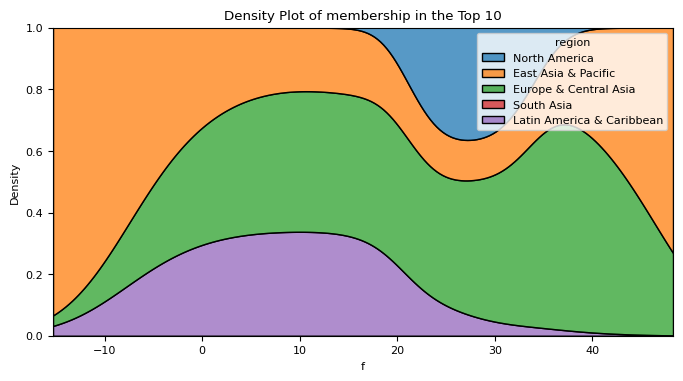

In [6]:
print(f'No, there are not african or middle eastern countries and most of the countries belongs to the World Bank region {df_temp.groupby("region").size().sort_values(ascending = False).reset_index().iloc[:1,:]["region"][0]}')

fig,ax = plt.subplots(figsize = (8,4))
sns.kdeplot(df_temp, x ='f', hue='region', warn_singular=False, multiple = 'fill')
plt.title('Density Plot of membership in the Top 10')
plt.plot()
print('Figure 1: Density plot of Frequency into the top 10 by Region')

#### 03.D. How is the GDP among countries and Continents?

The behaviour is heterogeneous, but speaking in terms of average values in 29 years is useless due to world economy growth in the period, so, the following figures will show the time series graphs where:
* The time series of The United States of America (USA) and China presents a bigger slope and size than other economies.
* The series of European countries present similar behaviours and shapes among them with slight size differences.
* South Asia and Latin American series consolidated as regions are lower than the others, the presence of those countries is less relevant than its European, North American, or East Asian peers into the top 10. It's important to consider that Mexico is in the Latin American Region and North America is only composed of The USA and Canada.
* Even when in the past section (Figure 1) the region with more countries in the top 10 economies is Europe, the join series of those countries has a lower level than the North American or East Asia joint series.



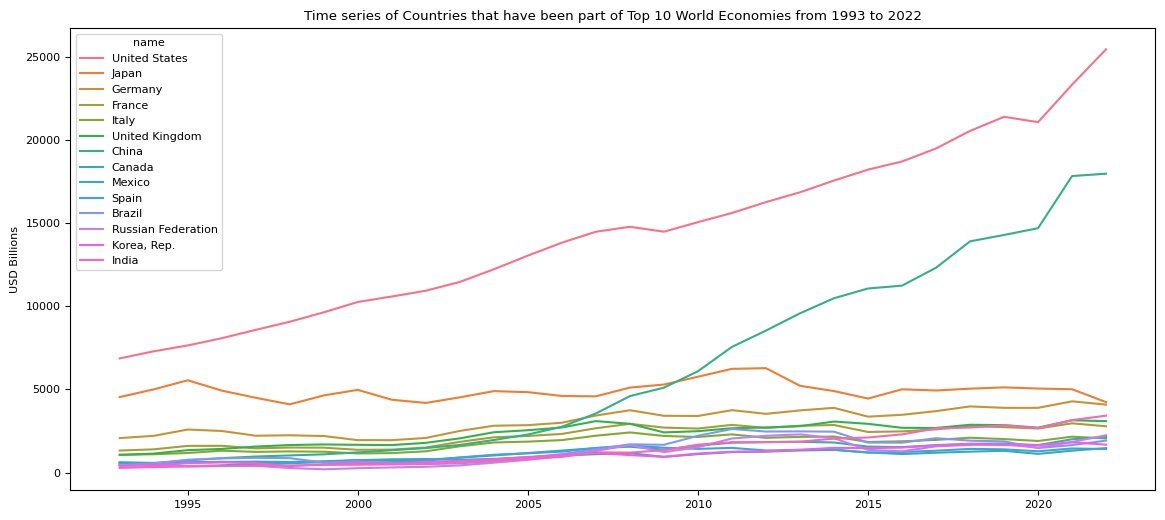

Figure 2: Time series by Country


In [7]:
fig,ax = plt.subplots(figsize = (14,6))
sns.lineplot(data = df, x = 'time' , y = 'gdp_Billions_USD' , hue = 'name', legend = 'brief')
ax.set(xlabel ='', ylabel ='USD Billions')
plt.title(f'Time series of Countries that have been part of Top 10 World Economies from {df.time.min()} to {df.time.max()}')
plt.show()
print('Figure 2: Time series by Country')

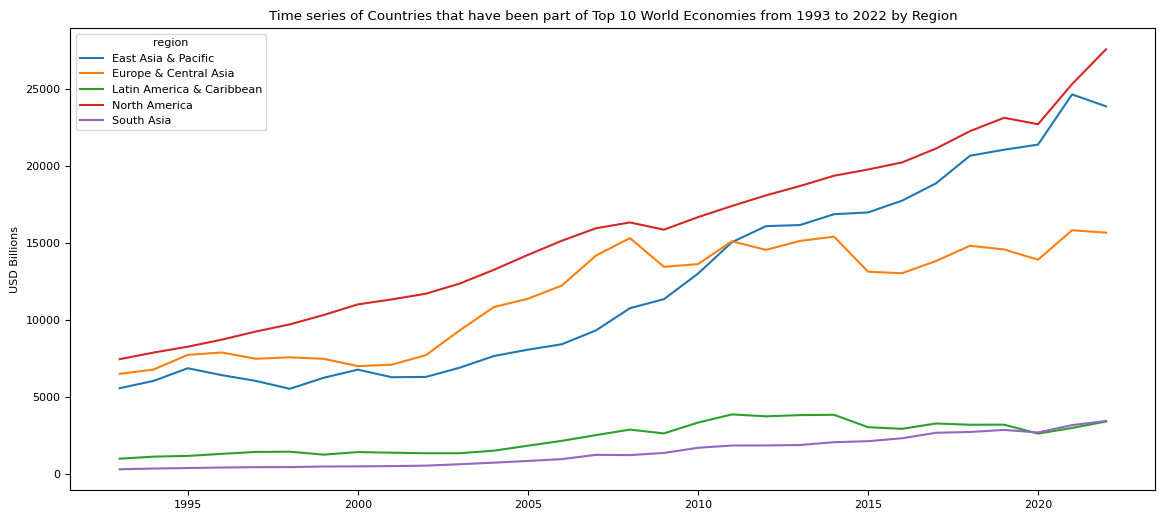

Figure 3: Time series by Region


In [8]:
fig,ax = plt.subplots(figsize = (14,6))
sns.lineplot(data = df.groupby(['region','time']).agg(gdp = ('gdp_Billions_USD','sum')), x = 'time' , y = 'gdp' , hue = 'region', legend = 'brief')
ax.set(xlabel ='', ylabel ='USD Billions')
plt.title(f'Time series of Countries that have been part of Top 10 World Economies from {df.time.min()} to {df.time.max()} by Region')
plt.show()
print('Figure 3: Time series by Region')

In [9]:
display(df_temp.groupby('region').agg(countries = ('name','count')).reset_index().sort_values('countries', ascending = False))
print('Table 2: Countries into Top 10 by region')

,region,countries
1,Europe & Central Asia,6
0,East Asia & Pacific,3
2,Latin America & Caribbean,2
3,North America,2
4,South Asia,1


Table 2: Countries into Top 10 by region


#### 03.E. How was the evolution of GDP by Country?

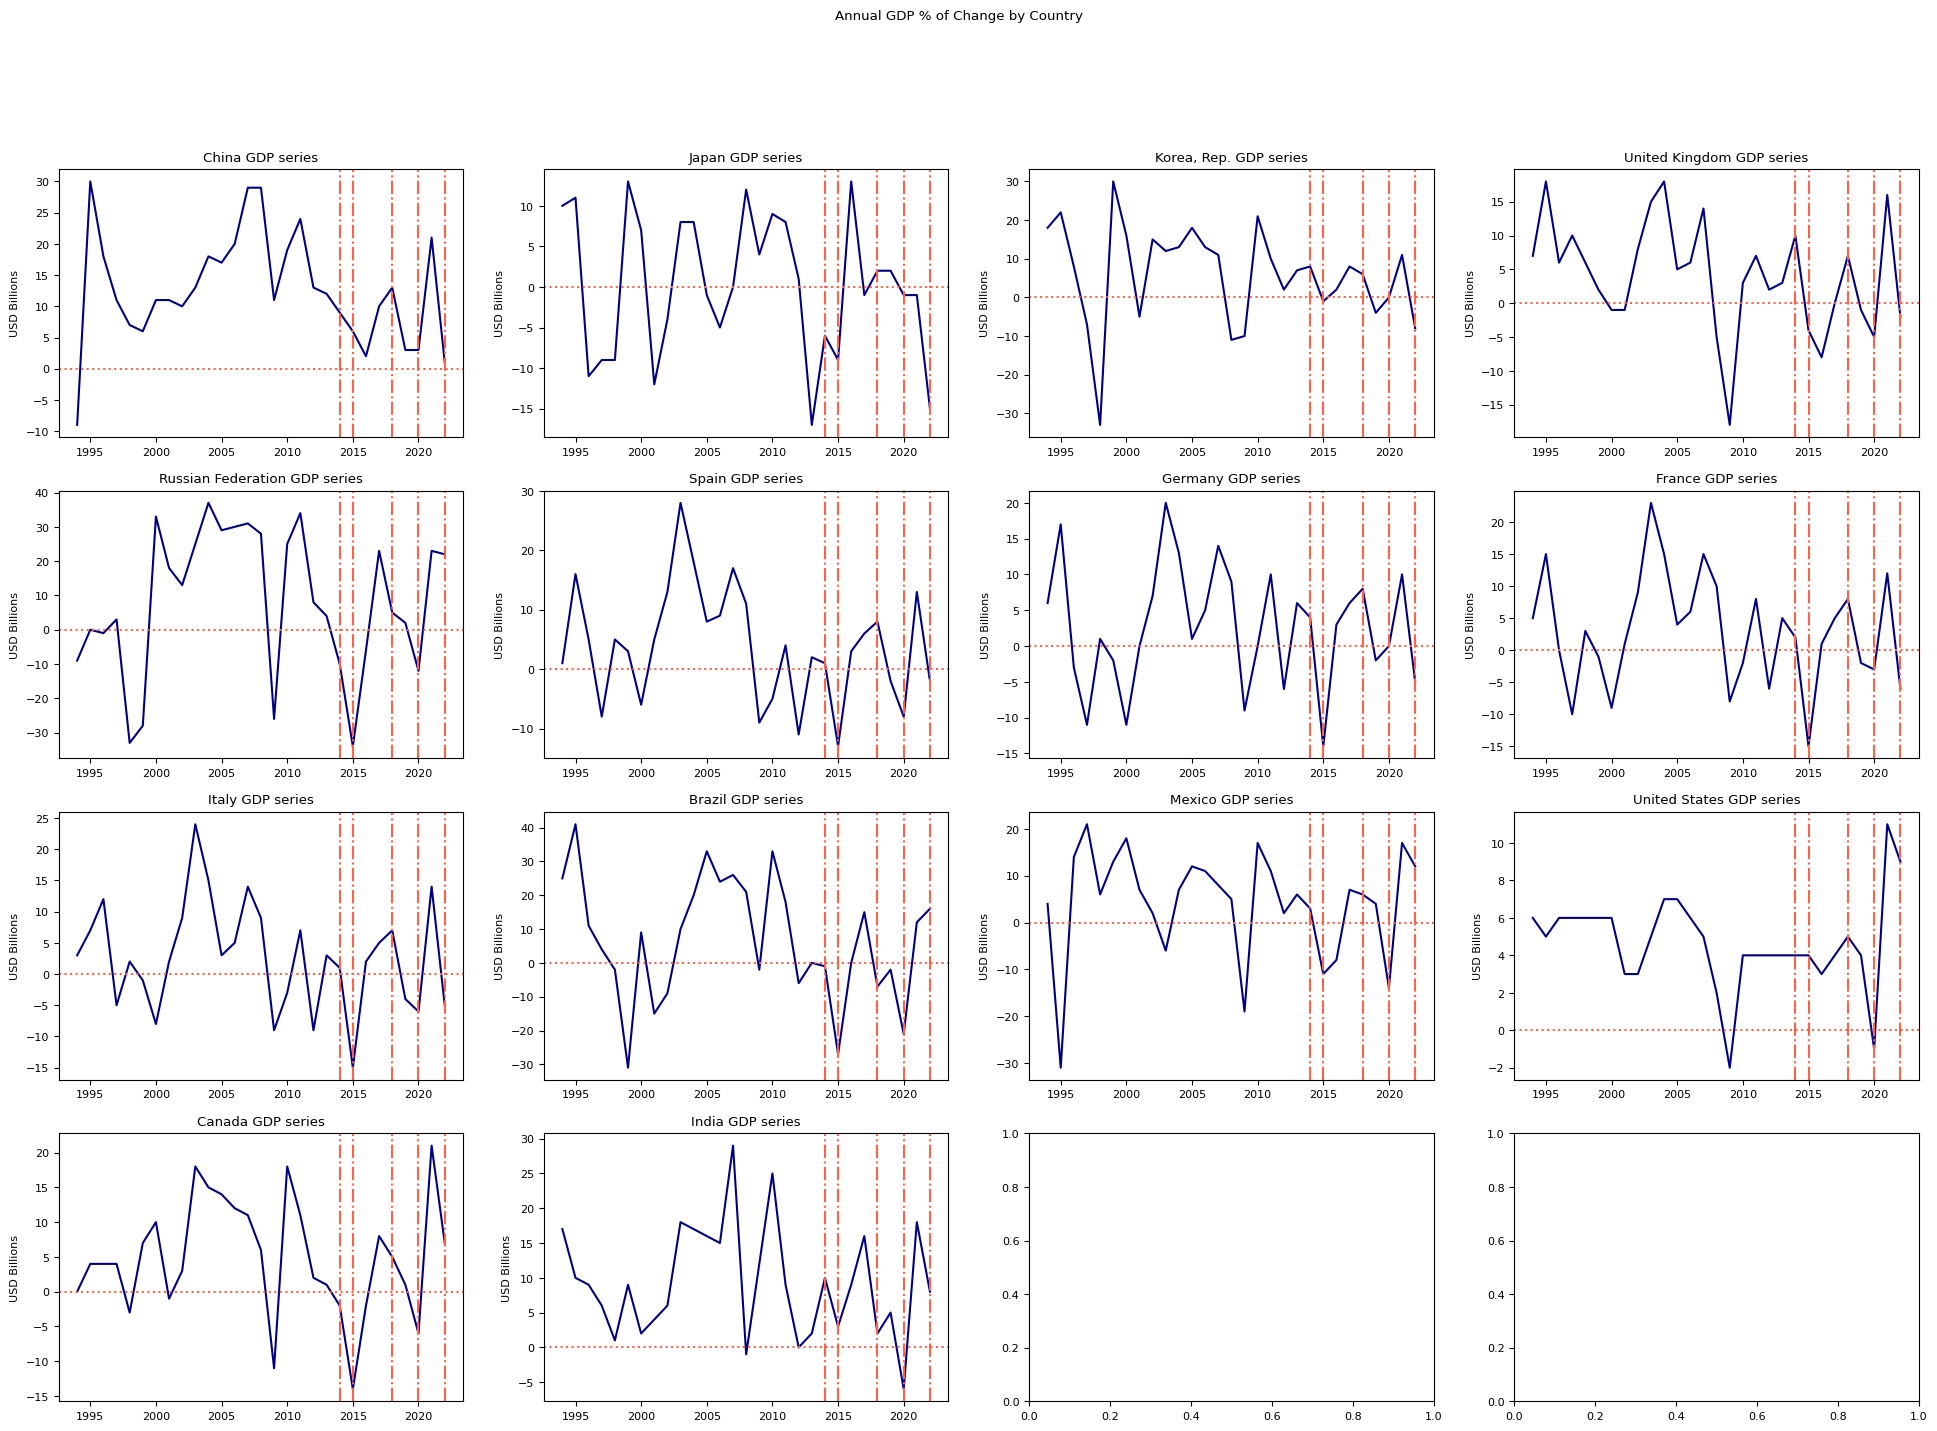

Figure 4: Annual %of Change by Country


In [10]:
aux_a = df.sort_values('region')['name'].unique()

numberOfPlots = len(aux_a)
numberOfCols = 4 if numberOfPlots >= 4 else int(numberOfPlots)
numberOfRows = int(np.ceil(numberOfPlots / numberOfCols))

figShapeHeight = numberOfRows * 4
figShapeWidth = numberOfCols * 6

# FIGURE CONFIG
fig, axes = plt.subplots(nrows=numberOfRows, ncols=numberOfCols, sharey=False, sharex=False, figsize=(figShapeWidth, figShapeHeight))
fig.suptitle('Annual GDP % of Change by Country')

for country, ax in zip(range(numberOfPlots), axes.flatten()):
    ts_grx(data=df, var_category='name', val_category=aux_a[country], var_target='level_growth', var_x='time', ax=ax, dummies = [2014,2015,2018,2020,2022], outliers = False)

plt.show()
print('Figure 4: Annual %of Change by Country')

The evolution over the years has been heterogeneous where:

* Only China has been growing sustainable over the years, with its lowest value in 2022
* The behaviour is more similar among Continental European Countries, not considering The United Kingdom because it doesn't fall beyond 0 in all the same periods.
* India has been mostly growing but in two periods, with the lowest value in 2020.
* The United States economy has also been growing but in two periods, 2009 and 2020 and has the steadiest pattern among countries and with the lower range of values (-2 to 10)
* The Russian Federation, Korea, Brazil, and Mexico reached the lowest value in USD Billions, but their highest peaks are different, where Brazil and The Russian Federation reached the highest ones.
* Between 2009 and 2021, the patterns of the Canadian and Russian series are similar, this can be interesting to be analyzed into a cluster analysis in another project.


#### 03.F. Which countries have the largest increase of GDP in the last decade?

Due to the differences in the variable magnitude and range by country, this question will be answered in two parts: <br> * one considering the nominal change as {‘nominal_evol =  GDP in 2022 – GDP in 2013’}, <br> * on the other hand a comparable metric, the percentage of change as {‘%_evol = nominal / GDP in 2013’}

In [11]:
max_date = df_base['time'].max() 
min_date = max_date - 9

df_temp = df_base[df_base['time'] == min_date][['country_iso3','name','level']].sort_values('country_iso3').reset_index(drop = True)
df_temp = df_temp.merge(df_base[df_base['time'] == max_date][['country_iso3','level']], on = 'country_iso3', how = 'left', suffixes= [min_date,max_date])
df_temp['nominal_evol (USD Billions)'] = df_temp[f'level{max_date}'] - df_temp[f'level{min_date}'] 
df_temp['%_evol'] = df_temp['nominal_evol (USD Billions)'] / df_temp[f'level{min_date}'] * 100

df_temp['nominal_evol (USD Billions)'] = np.round(df_temp['nominal_evol (USD Billions)'] / 1000000000,0)

t_temp = df_temp[['name','nominal_evol (USD Billions)']].sort_values('nominal_evol (USD Billions)',ascending = False).head(5)

display(t_temp)
print(f'Table 3: Top 5 countries by nominal GDP evolution in USD Billions from {min_date} to {max_date}')
print(f'\nOf the top 5 countries {(t_temp.name.isin(df.name.unique()) == False).sum()} are not into the top 10 world economies {t_temp[t_temp.name.isin(df.name.unique()) == False].name.unique()}), on the other hand, the evolution of the two main (USA and China) it was very close in nominal values')


,name,nominal_evol (USD Billions)
155,United States,8597.0
29,China,8393.0
71,India,1560.0
37,Cuba,556.0
70,Indonesia,407.0


Table 3: Top 5 countries by nominal GDP evolution in USD Billions from 2013 to 2022

Of the top 5 countries 2 are not into the top 10 world economies ['Cuba' 'Indonesia']), on the other hand, the evolution of the two main (USA and China) it was very close in nominal values


The cuba values are unexpected, this could mean an error during the ETL but this values are in the source: https://data.worldbank.org/indicator/NY.GDP.MKTP.CD?end=2022&locations=CU&start=2013&view=chart

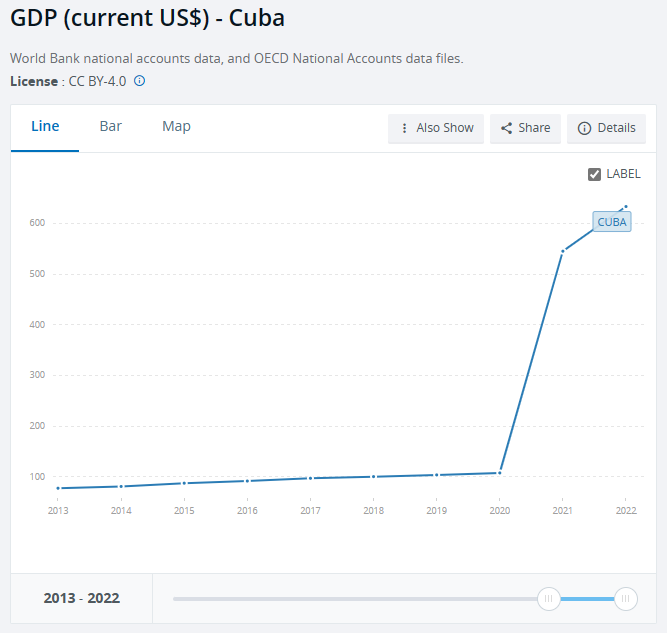

In [12]:
t_temp = df_temp[['name','%_evol']].sort_values('%_evol',ascending = False).head(5)

display(t_temp)
print(f'Table 4: Top 5 countries by % GDP evolution from {min_date} to {max_date}')
print(f'\nOf the top 5 countries {(t_temp.name.isin(df.name.unique()) == False).sum()} are not into the top 10 world economies {t_temp[t_temp.name.isin(df.name.unique()) == False].name.unique()}), on the other hand, the evolution of the two main (USA and China) it was very close in nominal values')

,name,%_evol
37,Cuba,721.074169
66,Guyana,253.145189
14,Bangladesh,206.820215
49,Ethiopia(excludes Eritrea),166.081967
59,Guinea,150.688758


Table 4: Top 5 countries by % GDP evolution from 2013 to 2022

Of the top 5 countries 5 are not into the top 10 world economies ['Cuba' 'Guyana' 'Bangladesh' 'Ethiopia(excludes Eritrea)' 'Guinea']), on the other hand, the evolution of the two main (USA and China) it was very close in nominal values


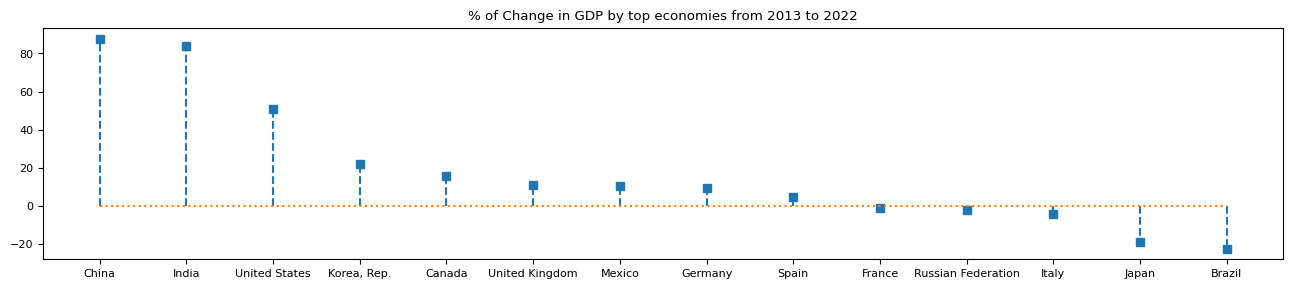

Figure 5: Total % of Change by Country


In [13]:
t_temp = df_temp.copy()[df_temp['country_iso3'].isin(df['country_iso3'].unique())].sort_values('%_evol', ascending = False)

plt.figure(figsize=(16,3))
plt.stem(t_temp['name'], 
         t_temp['%_evol'], 
         markerfmt = 's', linefmt='--', basefmt = ':')

plt.title(f'% of Change in GDP by top economies from {min_date} to {max_date}')
plt.show()
print('Figure 5: Total % of Change by Country')

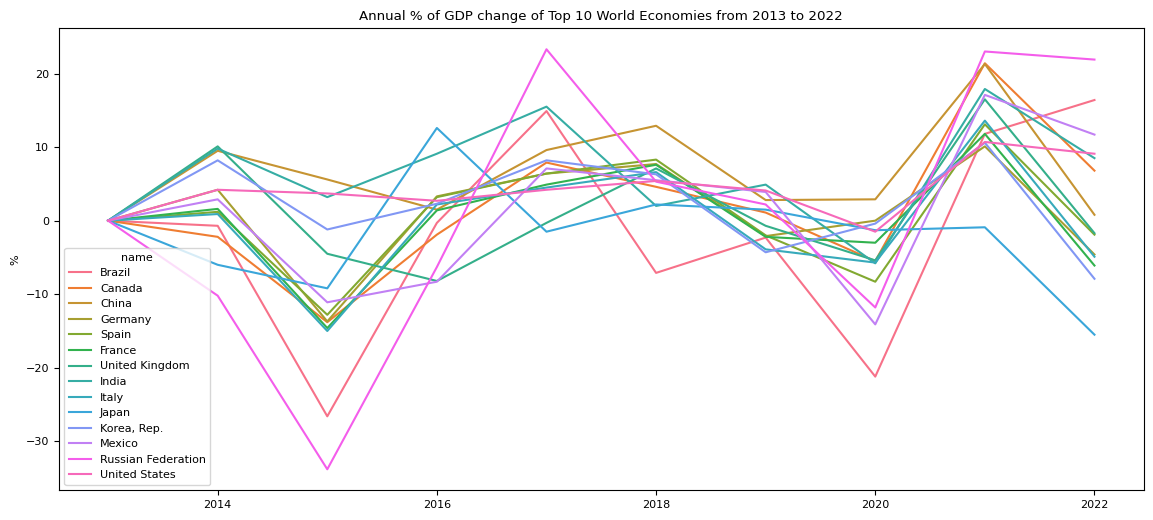

Figure 6: Annual values by Country


In [14]:
t_temp = df[df['time'] >= min_date][['time','country_iso3','name','gdp_Billions_USD']].sort_values(['country_iso3','time']).reset_index(drop = True)

# Step 2: Calculate percentage change within each group
t_temp['%_of_change'] = np.round(t_temp.groupby('country_iso3')['gdp_Billions_USD'].pct_change() * 100,1).fillna(0) 

fig,ax = plt.subplots(figsize = (14,6))
sns.lineplot(data = t_temp, x = 'time' , y = '%_of_change' , hue = 'name', legend = 'brief')
ax.set(xlabel ='', ylabel ='%')
plt.title(f'Annual % of GDP change of Top 10 World Economies from {min_date} to {max_date}')
plt.show()
print('Figure 6: Annual values by Country')

#### 03.G. The time series comply with the Stationary assumption?

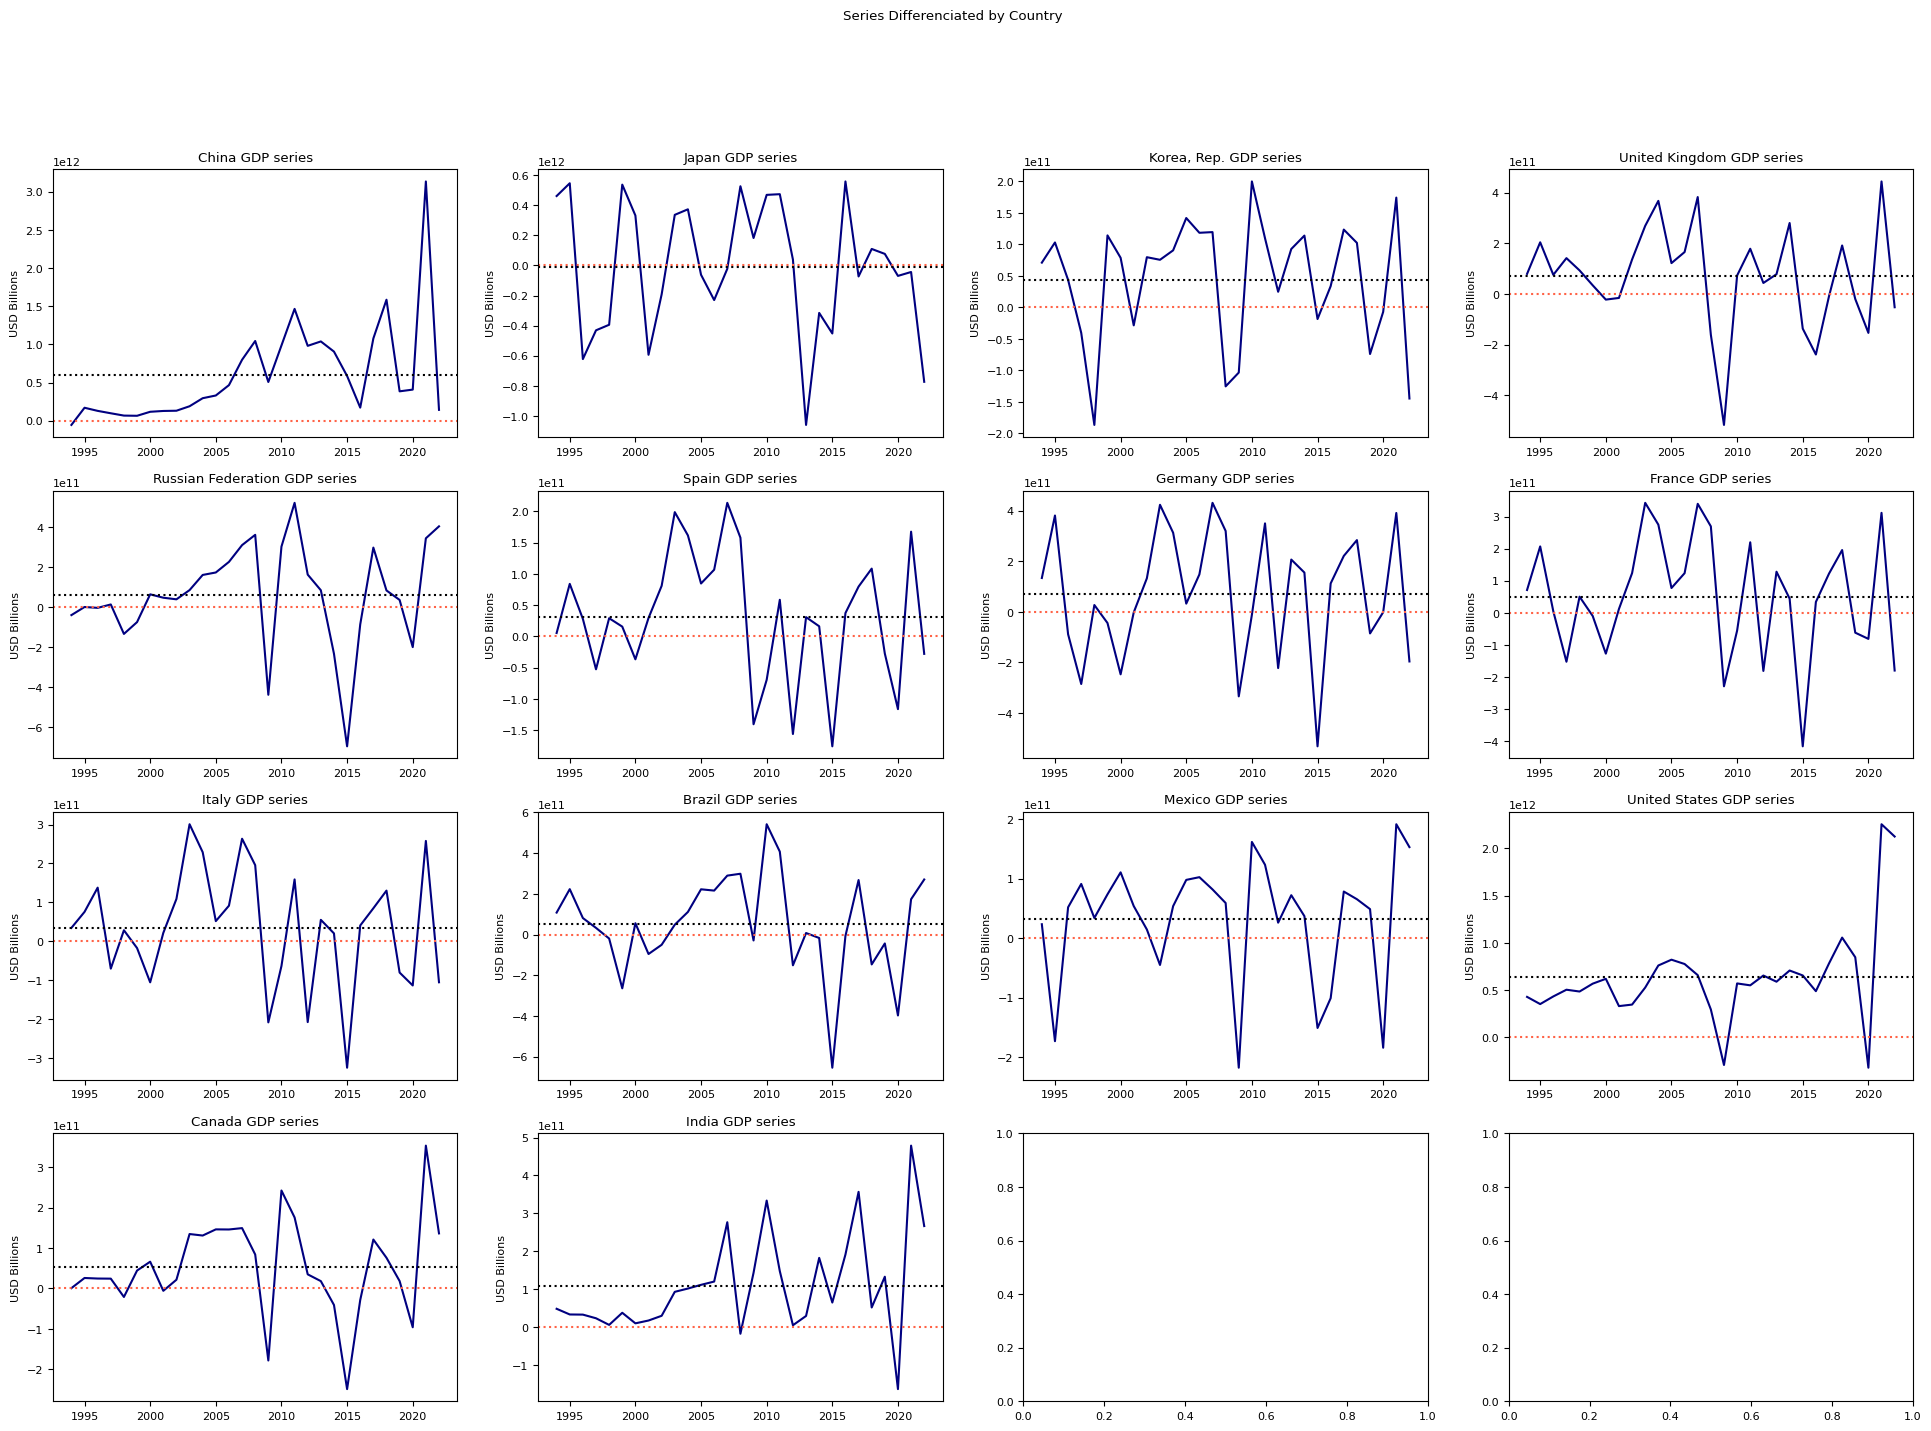

Figure 7: Annual Differenciated Time Series by Country


In [15]:
aux_a = df.sort_values('region')['name'].unique()

numberOfPlots = len(aux_a)
numberOfCols = 4 if numberOfPlots >= 4 else int(numberOfPlots)
numberOfRows = int(np.ceil(numberOfPlots / numberOfCols))

figShapeHeight = numberOfRows * 4
figShapeWidth = numberOfCols * 6

# FIGURE CONFIG
fig, axes = plt.subplots(nrows=numberOfRows, ncols=numberOfCols, sharey=False, sharex=False, figsize=(figShapeWidth, figShapeHeight))
fig.suptitle('Series Differenciated by Country')

for country, ax in zip(range(numberOfPlots), axes.flatten()):
    ts_grx(data=df, var_category='name', val_category=aux_a[country], var_target='level_diff', var_x='time', ax=ax, outliers = False, mean_line = True)

plt.show()
print('Figure 7: Annual Differenciated Time Series by Country')

To determine properly if a series complies with the Stationary Assumption its necessary to apply statistical tests, but a preliminary graphical analysis could give us an idea if the series values change around their mean (black dotted line), but this is not the case for the original series and even the case of all the differentiated series neither, which means that the series could not be stationary and will need another transformation that a simple differenciation.

In [16]:
countries = df[['country_iso3','name']].drop_duplicates()
countries = list(zip(countries.country_iso3,countries.name))

adf_results = pd.DataFrame()

for c_code, c_name in countries:
    data = df[df['country_iso3'] == c_code].dropna().reset_index(drop =True).sort_values('time',ascending = True).copy()['level']
    test = adfuller(data, regresults = True)
    test = pd.DataFrame([{'economy':c_name,'adf':test[0],'pvalue':test[1],'diff':0,'stationary': test[1] <= 0.05}])

    adf_results = pd.concat([adf_results,test])

    iters = 0

    while test.stationary.values[0] == False:
        iters += 1
        data = data.diff().dropna()
        test = adfuller(data, regresults = True)
        test = pd.DataFrame([{'economy':c_name,'adf':test[0],'pvalue':test[1],'diff':iters,'stationary': test[1] <= 0.05}])

        adf_results = pd.concat([adf_results,test])

        if iter == 5: break

adf_results = adf_results[adf_results['stationary']].reset_index(drop = True)
print(f'{len(adf_results.economy.unique())} countries of 14 has been analyzed')
display(adf_results)
print(f'''Only {adf_results[adf_results["diff"] >1].shape[0]} series needed more than 1 differentiations,\n{adf_results[adf_results["diff"] >1].economy}
      \non the other hand, {adf_results[adf_results["diff"] <1].shape[0]} series needed 0 differentiations, so, no need stationarity moddeling\n{adf_results[adf_results["diff"] <1].economy}''')
print('Table 5: Results of Augmented Dickey-Fuller test over selected countries')


14 countries of 14 has been analyzed


,economy,adf,pvalue,diff,stationary
0,United States,-5.909848,2.654729e-07,1,True
1,Japan,-4.370209,3.350170e-04,1,True
2,Germany,-3.518627,7.521401e-03,1,True
3,France,-3.135258,2.405163e-02,0,True
4,Italy,-4.097416,9.780940e-04,0,True
5,United Kingdom,-7.241619,1.877870e-10,2,True
6,China,-5.757783,5.765805e-07,4,True
7,Canada,-3.653600,4.815229e-03,1,True
8,Mexico,-56.003903,0.000000e+00,8,True
9,Spain,-4.021634,1.301373e-03,0,True


Only 4 series needed more than 1 differentiations,
5     United Kingdom
6              China
8             Mexico
10            Brazil
Name: economy, dtype: object
      
on the other hand, 3 series needed 0 differentiations, so, no need stationarity moddeling
3    France
4     Italy
9     Spain
Name: economy, dtype: object
Table 5: Results of Augmented Dickey-Fuller test over selected countries


This means that we are going to need to apply the differentiation linked to the test into the forecasting models and the variable created in the ETL with a simple differentiation won't be useful for modelling, this also means that not all the series will have the same Train / Test split considering that each differenciation takes 1 timestamp away from the series.

#### 03.H. Are there valuable insights about outliers?

In [17]:
aux_a = df[df['level_outlier'] == True].sort_values('region')['name'].unique()
aux_b = df[df['level_outlier'] == False].sort_values('region')['name'].unique()

print(f'There are {len(aux_a)} countries with possible outliers considering the technique of Hampel Filter, those countries are: {aux_a},\non the other hand, for the following {len(aux_b)} countries there weren\'t detected outliers: {aux_b}')

There are 11 countries with possible outliers considering the technique of Hampel Filter, those countries are: ['Japan' 'Korea, Rep.' 'Russian Federation' 'Spain' 'United Kingdom'
 'Italy' 'France' 'Germany' 'Brazil' 'Mexico' 'Canada'],
on the other hand, for the following 14 countries there weren't detected outliers: ['China' 'Japan' 'Korea, Rep.' 'Russian Federation' 'United Kingdom'
 'Spain' 'Germany' 'France' 'Italy' 'Brazil' 'Mexico' 'United States'
 'Canada' 'India']


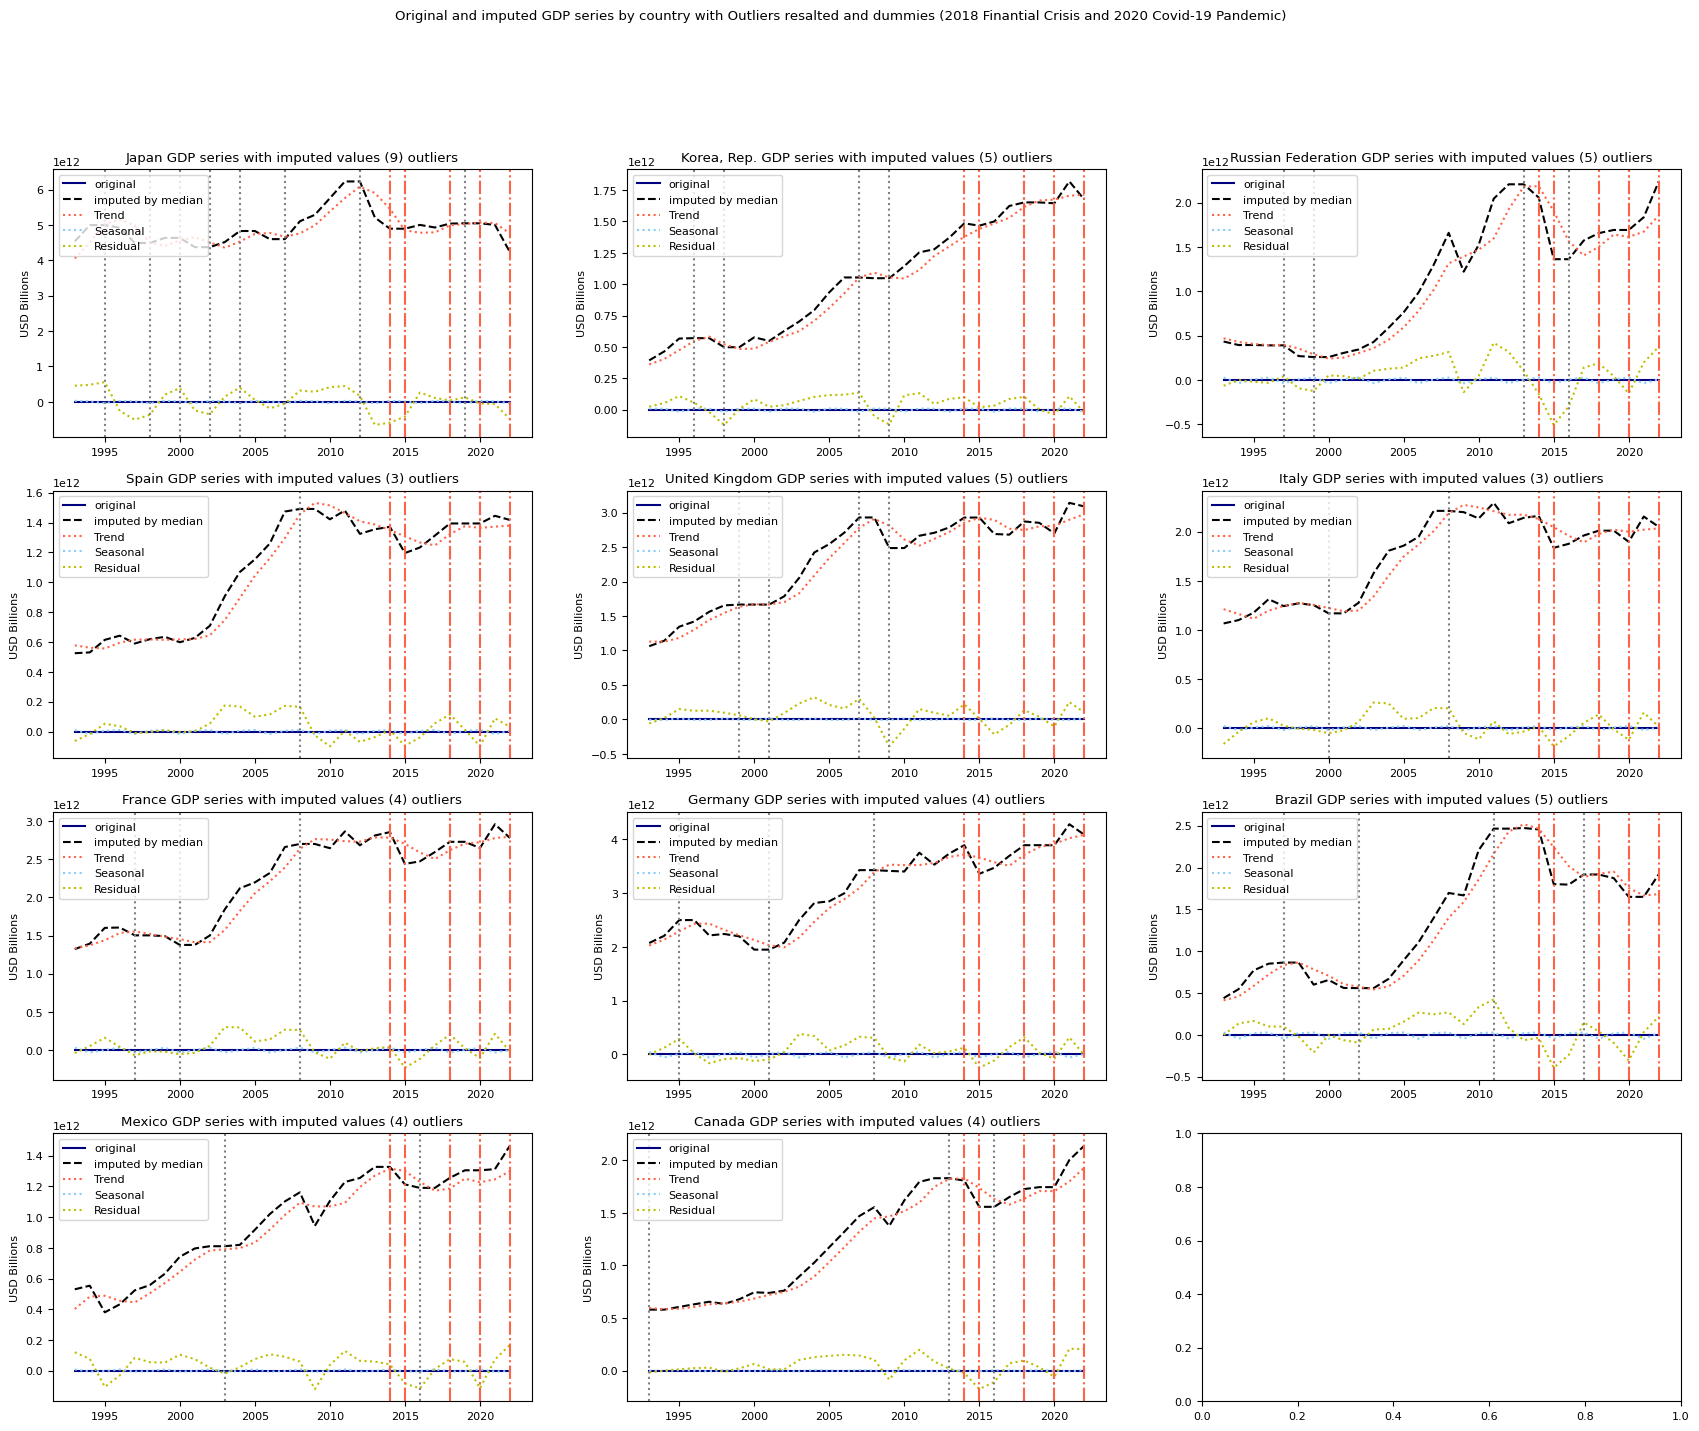

Figure 8: Series with Outliers, Imputations and Time Series Components by Country


In [18]:
numberOfPlots = len(aux_a)
numberOfCols = 3 if numberOfPlots >= 3 else int(numberOfPlots)
numberOfRows = int(np.ceil(numberOfPlots / numberOfCols))

figShapeHeight = numberOfRows * 4
figShapeWidth = numberOfCols * 7

# FIGURE CONFIG
fig, axes = plt.subplots(nrows=numberOfRows, ncols=numberOfCols, sharey=False, sharex=False, figsize=(figShapeWidth, figShapeHeight))
fig.suptitle('Original and imputed GDP series by country with Outliers resalted and dummies (2018 Finantial Crisis and 2020 Covid-19 Pandemic)')

for country, ax in zip(range(numberOfPlots), axes.flatten()):
    outlier_ts_grx(data=df, var_category='name', val_category=aux_a[country], var_target='level', var_x='time', ax=ax, dummies = [2014,2015,2018,2020,2022], tsc = True)

plt.show()
print('Figure 8: Series with Outliers, Imputations and Time Series Components by Country')


In most countries, the outliers used to lie on peaks and valleys such as in Japan (1995, 2000, 2003, 2005, 2019) or Korea (1998, 2007,2009), and the major number of series original levels share the behaviour of the residual component, while the mean or imputed series follows the trend series.

This is important in case of applying classic models that consider time series components such as Exponential Smoothing or even STL, prophet should be able to handle these things, but even in the Machine / Dep learning models, this information is valuable because has the potential to reduce the errors making composed models with the residual component, just in case that the project goal wont be achieved with models based on level.


#### 03.I. The analysis with the planned dummy variables could drive into a better performance of models?

There is little information about the dummies, probably it won't be useful due to the lack of past values (all happened in recent history) but, for further or future steps, it could be valuable. It's important to consider also that this conclusion is made due to the change of patterns in the series during the last decade, if we don't consider enough past information the risk of capturing a partial trend would be higher.

#### 03.J. What is the potential of using the other variables from WDI into the model? 

In this case, we probably have little values to create enough lags considering that we need to make an 8-year forecast. Using the past value or 1 lag would take 9 timestamps + the one missed during the difference, and taking shorter range could increase the risk of capturing a partial trend and then the error. A good first step is making the models as simple as possible and after considering their performance it can be improved. But just to explore, let's analyze the impact on some countries.

There is a fact over the complementary series that can't be ignored, the other series doesn't have a 100% completion, which means those variables can't be used in the models having NA's, in this case, we are going to ignore that aiming to understand the causality in a same given period, the shorter one by variables availability.

To answer this question, the selected test is Granger Causality, before applying it all the series will be transformed considering a unitary root test (Augmented Dickey-Fuller) to comply with stationarity assumption.


In [19]:
%%capture

results = pd.DataFrame()

target =  'GDP_USD'
maxlag=3

variables = ['GDP_USD', 'GINI_per_capita', 'acapital_formation_%GDP', 'account_balance_%GDP', 'agriculture_%GDP',
            'consumer_price_idx_b2010', 'consumption_%GDP', 'exports_%GDP', 'foreign_investment_%GDP', 'gross_savings_%GDP', 
            'imports_%GDP', 'industry_%GDP', 'population', 'remittances_%GDP', 'services_%GDP']

for c_code, c_name in countries:
    data = df_granger[df_granger['country_iso3'] == c_code].dropna().reset_index(drop =True).sort_values('time',ascending = True).copy()[['country_iso3','time'] + variables]    

    #Stationary MOddeling
    for variable in variables:
        serie = data[variable]        
        test = adfuller(serie, regresults = True)
        test = pd.DataFrame([{'economy':c_name,'adf':test[0],'pvalue':test[1],'diff':0,'stationary': test[1] <= 0.05}])

        iters = 0

        while test.stationary.values[0] == False:
            iters += 1
            serie = serie.diff().dropna()
            test = adfuller(serie, regresults = True)
            test = pd.DataFrame([{'economy':c_name,'adf':test[0],'pvalue':test[1],'diff':iters,'stationary': test[1] <= 0.05}])

            if iter == 3: break
        
        data[variable] = serie

    data = data.dropna().reset_index(drop = True).sort_values('time',ascending = True)
    
    #Causality
    for variable in variables:
        if variable == target: continue

        gcausality = grangercausalitytests(x = data[[target,variable]], maxlag = maxlag)
        gcausality = [{'economy':c_name,'variable':variable, 'lag_1':gcausality[1][0]['ssr_ftest'][1] < 0.05 ,'lag_2':gcausality[2][0]['ssr_ftest'][1] < 0.05,'lag_3':gcausality[3][0]['ssr_ftest'][1] < 0.05}]

        results = pd.concat([results, pd.DataFrame(gcausality)])

results = results.groupby('variable').agg(lag1 = ('lag_1','sum'),lag2 = ('lag_2','sum'),lag3 = ('lag_3','sum')).reset_index()
results['%series_lag1'] = np.round(results['lag1'] / len(countries),1)*100
results['%series_lag2'] = np.round(results['lag2'] / len(countries),1)*100
results['%series_lag3'] = np.round(results['lag3'] / len(countries),1)*100
results['relevant'] = (results['lag1'] >0) | (results['lag2'] >0) | (results['lag3'] >0)

In [20]:
print(f'''Considering the {len(countries)} country series analyzed, {sum(results.relevant)} variables of {results.shape[0]} results relevant to the analysis for
      at least one series aiming to be used to predict the GDP series''')

display(results.sort_values(['lag1','lag2','lag3'], ascending = False).reset_index(drop = True))
print('Table 5: Results of Granger\'s Causality Test in selected countries over GDP Series')

Considering the 14 country series analyzed, 12 variables of 14 results relevant to the analysis for
      at least one series aiming to be used to predict the GDP series


,variable,lag1,lag2,lag3,%series_lag1,%series_lag2,%series_lag3,relevant
0,GINI_per_capita,5,3,4,40.0,20.0,30.0,True
1,imports_%GDP,4,1,0,30.0,10.0,0.0,True
2,consumer_price_idx_b2010,3,4,2,20.0,30.0,10.0,True
3,exports_%GDP,2,1,1,10.0,10.0,10.0,True
4,services_%GDP,2,1,1,10.0,10.0,10.0,True
5,industry_%GDP,2,1,0,10.0,10.0,0.0,True
6,acapital_formation_%GDP,2,0,0,10.0,0.0,0.0,True
7,population,1,2,1,10.0,10.0,10.0,True
8,consumption_%GDP,1,1,1,10.0,10.0,10.0,True
9,gross_savings_%GDP,1,1,0,10.0,10.0,0.0,True


Table 5: Results of Granger's Causality Test in selected countries over GDP Series


#### 03.K. What are the Autoregressive characteristics of each series? 

To answer this question only will be considered the selected series, all the series should pass over a similar path, but this will be done during the forecasting models. 

Having extracted the Autoregressive, Integrated and Moving components of each series (The Box-Jenkins criteria):
* Not all series should be modelled to handle the stationary assumptions.
* The major number of series consider an AR component to 9 lags.
* The behavior of each series is heterogeneous dynamic, countries like India only require three and two lags but France is 8 and 7 while the Integrated component is 0.

Considering all this information, the classic models will consider exactly the procedure of this section and it will be also tested for the other models but prophet due that prophet should be able to handle this quite automatically.


In [21]:
results = pd.DataFrame()

lags = 9
threshold = 0.2

for c_code, c_name in countries:
    data = df[df['country_iso3'] == c_code].dropna().reset_index(drop =True).sort_values('time',ascending = True).copy()['level'] 

    #Stationary MOddeling          
    test = adfuller(data, regresults = True)
    test = pd.DataFrame([{'economy':c_name,'adf':test[0],'pvalue':test[1],'diff':0,'stationary': test[1] <= 0.05}])

    iters = 0

    while test.stationary.values[0] == False:
        iters += 1
        data = data.diff().dropna()
        test = adfuller(data, regresults = True)
        test = pd.DataFrame([{'economy':c_name,'adf':test[0],'pvalue':test[1],'diff':iters,'stationary': test[1] <= 0.05}])

        if iter == 3: break

    #Functions
    acf_values = acf(data, nlags=lags)
    pacf_values = pacf(data, nlags=lags)


    # Extract AR components
    ar_order = [i for i, val in enumerate(pacf_values) if abs(val) > threshold]

    # Extract MA components
    ma_order = [i for i, val in enumerate(acf_values) if abs(val) > threshold]

    # Extractin I component
    i_order = iters

    series_order = [{'code':c_code,'economy':c_name,'ar_order':ar_order,'i_order':i_order,'ma_order':ma_order}]

    results = pd.concat([results, pd.DataFrame(series_order)])

display(results)
print('Table 6: Autorregressive characteristics of selected Series')

,code,economy,ar_order,i_order,ma_order
0,USA,United States,"[0, 2, 5, 8, 9]",1,"[0, 2, 3, 9]"
0,JPN,Japan,"[0, 2, 3, 6, 9]",1,"[0, 2, 3]"
0,DEU,Germany,"[0, 2, 3, 6, 7, 8]",1,"[0, 2]"
0,FRA,France,"[0, 1, 4, 6, 7, 8, 9]",0,"[0, 1, 2, 3, 4, 5, 6]"
0,ITA,Italy,"[0, 1, 4, 6, 7, 8]",0,"[0, 1, 2, 3, 4, 5, 6]"
0,GBR,United Kingdom,"[0, 2, 5, 6, 7, 8, 9]",2,"[0, 2, 4, 5, 7, 9]"
0,CHN,China,"[0, 1, 2, 3, 4, 6, 7, 8, 9]",4,"[0, 1, 2, 3, 7, 8]"
0,CAN,Canada,"[0, 1, 2, 6, 8, 9]",1,"[0, 1, 6, 9]"
0,MEX,Mexico,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",8,"[0, 1, 2, 3, 5, 6]"
0,ESP,Spain,"[0, 1, 2, 4, 6, 7]",0,"[0, 1, 2, 3, 4, 5, 6]"


Table 6: Autorregressive characteristics of selected Series


#### 03.L. How many series will be analyzed in the Forecasting Analysis?


In [22]:
print(f'The forecasting analysis will consider {len(df_base.country_iso3.unique())}, using all the available data after the ETL')

The forecasting analysis will consider 164, using all the available data after the ETL


#### 03.M What is the level of completeness of the other WDI?
The NA's obtained during the ETL which reflects the non available values in the source were extracted to a specific dataframe "ft_nas.csv.gz"

Not all variables have values in all the timestamps, to be able to utilize those variables in forecast models, the variables should be complete in origin, or an imputation analysis shall be done as part of the pre-treatment.

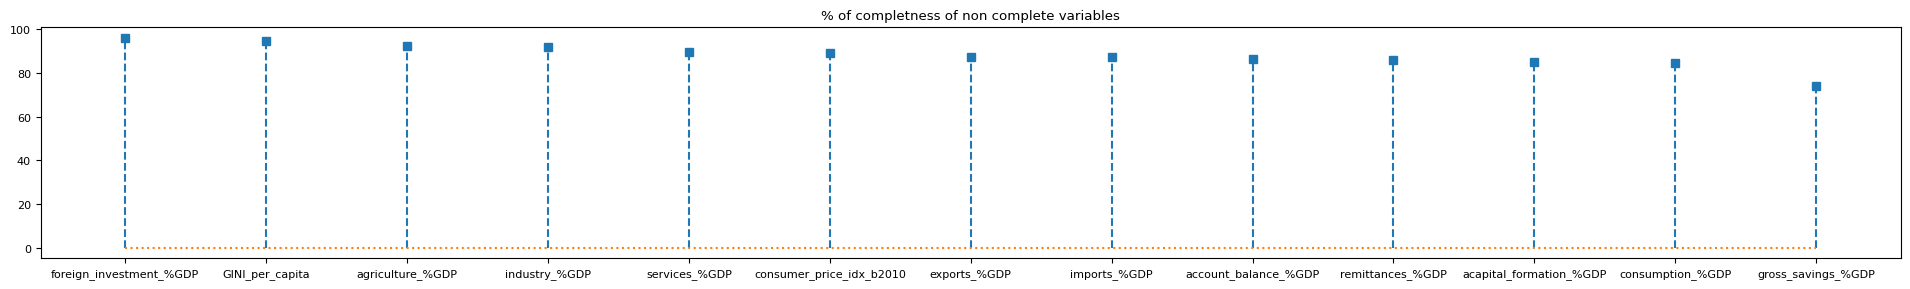

Figure 9: % of completness of non complete variables


In [23]:
t_temp = (100 - ((df_nas.drop(columns = ['country_iso3','time']).sum() / (df_nas.shape[0])) * 100)).reset_index().rename(columns = {'index':'variable',0:'%_of_availability'}).sort_values('%_of_availability', ascending = False)
t_temp = t_temp[t_temp['%_of_availability'] < 100]

plt.figure(figsize=(24,3))
plt.stem(t_temp['variable'], 
         t_temp['%_of_availability'], 
         markerfmt = 's', linefmt='--', basefmt = ':')

plt.title(f'% of completness of non complete variables')
plt.show()
print('Figure 9: % of completness of non complete variables')

### 04. Conclusions

1. The series presents a heterogeneous behaviour in general terms but there are some similitudes among them, this could be explored in another project analyzing Time Series Clustering.
2. The two main economies are quite different in trend and levels to the rest which probably won't change in the models.
3. The USA economy seems to be the less volatile.
4. The dispersion of levels is important among countries. 
5. During the last decade the trend seems to be affected and decelerating the series but China and The USA.
6. China is the only economy without contractions in the given period.
7. Many situations can drive a change in the patterns over the last years, but due to its recent occurrence, it won't be useful for this modelling.
8. For some countries the outliers happened in the peaks and valleys of the Residual component
9. Not all the series will need the same treatment during the model's pre-processing and the autoregressive characteristics should be included.
10. The auxiliary variables could be useful if the time series would be complete.
11. Creating Feature Engineering during the ETL process resulted in insufficient due to the new information gathering during this EDA.


In [24]:
!jupyter nbconvert --to webpdf --allow-chromium-download eda.ipynb

[NbConvertApp] Converting notebook eda.ipynb to webpdf
[NbConvertApp] WARNING | Alternative text is missing on 9 image(s).
[NbConvertApp] Building PDF
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 2482327 bytes to eda.pdf
